*******************************
Data Cleaning activity started!
*******************************
Cleaning Financial Ratio data for : Tata Chemicals
Cleaning Financial Ratio data for : Reliance Power
Cleaning Financial Ratio data for : Abbott
Cleaning Financial Ratio data for : JSW Steel
Cleaning Financial Ratio data for : Mahindra
Cleaning Financial Ratio data for : Fortis
Cleaning Financial Ratio data for : Adani
Cleaning Financial Ratio data for : ONGC Videsh
Cleaning Financial Ratio data for : Rain
Cleaning Financial Ratio data for : Hero
Cleaning Financial Ratio data for : Sun Pharma
Cleaning Financial Ratio data for : Piramal Enterprises
Cleaning Financial Ratio data for : IOC
Cleaning Financial Ratio data for : Ultratech Cement
Cleaning Financial Ratio data for : NTPC
Cleaning Financial Ratio data for : Pfizer
Cleaning Financial Ratio data for : Torrent 
Cleaning Financial Ratio data for : Exide
Cleaning Financial Ratio data for : Cipla
Cleaning Financial Ratio data for : JSW Ener

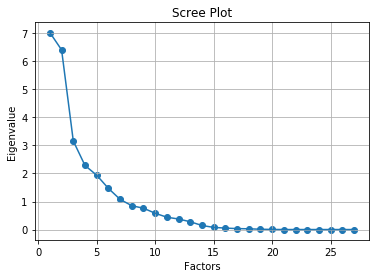

In [7]:
# Import Pandas library
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity


# Set data precision for the decimals
#pd.options.display.precision=2
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Read the Excel file
rawxls = pd.ExcelFile('2. Manufacturing.xlsx')
industryxls = pd.read_excel('industryclass.xlsx')

# Extract the sheet names from the excel file into a variable
companies = rawxls.sheet_names
#print(companies)

# Create an empty lists: FinRatiolist / SharePricelist
FinRatiolist = []    #Long Term
SharePricelist = []  #Short term

# Initialize an index variable with default value as Zero
idx=0
companyname=''

print("*******************************")
print("Data Cleaning activity started!")
print("*******************************")
# Loop the Sheet names in the Excel file
for company in companies:
    df = pd.DataFrame(columns=['Company','preOpen','preClose','postOpen','postClose','preGain','postGain'])
    if idx%2 != 0 :
        #If the sheet is for Share Prices (Odd index):
        #Increment the index value to navigate to the next sheet
        idx+=1
        # Go to Next sheet
        continue

    #If the sheet is for Financial Ratios (Even index):    
    companyname=company
    print('Cleaning Financial Ratio data for :',companyname)   
    # Read the Excel based on the sheet name and load it into a temporary dataframe
    df_finratio = pd.read_excel(rawxls, sheet_name=company)

    # Rename the zeroth column as it is not unique in the excel (has company name attached to column header)
    df_finratio.rename(columns={ df_finratio.columns[0]: "FinRatio" }, inplace = True)

    # Add a new column to store the company name against each Ratio
    df_finratio['Company'] = companyname

    # Remove the columns where all rows are null
    #df_finratio = df_finratio.loc[:, (df_finratio.isnull().sum(axis=0) < len(df_finratio))]
    df_finratio=df_finratio.dropna(axis=1,how='all')
     # Replace null values by zero
    df_finratio.fillna(0, inplace=True)

    # Filter the rows which are not required (some header rows where there are no ratios specified)
    df_finratio = df_finratio[df_finratio['FinRatio'] !=0] 

    # Remove Pre-Mean and Post-Mean columns as it is not available in all sheets(Column Names - Unnamed: 4 & Unnamed: 9)
    if len(df_finratio.columns)==11:# where Pre-Mean and Post-Mean columns are available
        df_finratio = df_finratio.drop([df_finratio.columns[4] , df_finratio.columns[9]] , axis='columns')
        
    # Rename the Unnamed columns based on the Column Index
    df_finratio = df_finratio.rename(columns={df_finratio.columns[1]: 'Y-3', 
                                              df_finratio.columns[2]: 'Y-2', 
                                              df_finratio.columns[3]: 'Y-1', 
                                              df_finratio.columns[4]: 'Y', 
                                              df_finratio.columns[5]: 'Y+1', 
                                              df_finratio.columns[6]: 'Y+2', 
                                              df_finratio.columns[7]: 'Y+3'})
  
    # Add New Columns : PreMean, PostMean and MergeYear and default it to Zero
    df_finratio['PreMean']= df_finratio.iloc[:,1:4].mean(axis=1)
    df_finratio['PreSD']= df_finratio.iloc[:,1:4].std(axis=1)
    df_finratio['PostMean']= df_finratio.iloc[:,5:8].mean(axis=1)
    df_finratio['PostSD']= df_finratio.iloc[:,5:8].std(axis=1)
    df_finratio['MergeYear']=0
 
     # Add the data frame to the List (Financial Ratio list)
    FinRatiolist.append(df_finratio)
    
    #Increment the index value to navigate to the next sheet    
    idx+=1
    #print(idx)

    #Go to Next sheet
    continue
    
# Concatenate all Financial Ratios into a single dataframe
df_allfinratio= pd.concat(FinRatiolist)
finds=df_allfinratio[['Company','FinRatio','PreMean','PostMean','PreSD','PostSD']]

#Transpose dataframe
df = finds.groupby(['Company','FinRatio']).sum().transpose().stack(0).reset_index()

# Replace null values by zero
df.fillna(0, inplace=True)

#Remove/filter columns where all values are 0
df = df.loc[:, (df != 0).any(axis=0)]

#Factor Analysis
fanads = df.copy()

#Remove 'level_0', 'Company'
fanads.drop(['level_0', 'Company'],axis=1,inplace=True)
fanads.dropna(inplace=True)
print(fanads.head())


#Export to Excel
fanads.to_excel('fanads.xlsx')


#KMO test
kmo_all,kmo_model=calculate_kmo(fanads)
print('KMO:',kmo_model)
#Bartlett's test
chi_square_value,p_value=calculate_bartlett_sphericity(fanads)
print('Chi Square:',chi_square_value, 'p_value:',p_value)

'''
KMO: 0.5699752195299366
Chi Square: 8755.734395055617 p_value: 0.0
'''
#Since KMO and Bartlett tests are passed, we go for factor analysis
# Create factor analysis object and perform factor analysis
fa=FactorAnalyzer()
print(fa)
fa.fit(fanads)
#fa.analyze(fanads, 25, rotation=None)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
print('Eigen Values:',np.around(ev))
print('Eigen Vectors',np.around(v))



# Create scree plot using matplotlib
plt.scatter(range(1,fanads.shape[1]+1),ev)
plt.plot(range(1,fanads.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()



'''
#Principal Component Analysis

pca = PCA(n_components=2)
# Separating out the features
x = df.iloc[:,3:].values
z=pd.DataFrame(data=x[1:,1:],index=x[1:,0],columns=x[0,1:]) 
#print(z.head())

principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
print(principalDf)
'''


#Re-transpose dataframe
df2=df.groupby(['Company','level_0']).sum().transpose().stack(0).reset_index()
df2["Measurement"] = ''

#Assign Measurement categories
df2.loc[df2['FinRatio']== 'PBDIT Margin (%)', 'Measurement'] = 'Profitability Ratios'
df2.loc[df2['FinRatio']== 'PBIT Margin (%)', 'Measurement'] = 'Profitability Ratios'
df2.loc[df2['FinRatio']== 'PBT Margin (%)', 'Measurement'] = 'Profitability Ratios'
df2.loc[df2['FinRatio']== 'Net Profit Margin (%)', 'Measurement'] = 'Profitability Ratios'
df2.loc[df2['FinRatio']== 'Return on Networth / Equity (%)', 'Measurement'] = 'Profitability Ratios'
df2.loc[df2['FinRatio']== 'Return on Capital Employed (%)', 'Measurement'] = 'Profitability Ratios'
df2.loc[df2['FinRatio']== 'Return on Assets (%)', 'Measurement'] = 'Profitability Ratios'
df2.loc[df2['FinRatio']== 'Basic EPS (Rs.)', 'Measurement'] = 'Profitability Ratios'
df2.loc[df2['FinRatio']== 'Diluted EPS (Rs.)', 'Measurement'] = 'Profitability Ratios'
df2.loc[df2['FinRatio']== 'Cash EPS (Rs.)', 'Measurement'] = 'Profitability Ratios'
df2.loc[df2['FinRatio']== 'Total Debt/Equity (X)', 'Measurement'] = 'Leverage Ratios'
df2.loc[df2['FinRatio']== 'Current Ratio (X)', 'Measurement'] = 'Liquidity Ratios'
df2.loc[df2['FinRatio']== 'Quick Ratio (X)', 'Measurement'] = 'Liquidity Ratios'
df2.loc[df2['FinRatio']== 'Inventory Turnover Ratio (X)', 'Measurement'] = 'Eficiency'
df2.loc[df2['FinRatio']== 'Earnings Retention Ratio (%)', 'Measurement'] = 'Eficiency'
df2.loc[df2['FinRatio']== 'Cash Earnings Retention Ratio (%)', 'Measurement'] = 'Eficiency'
df2.loc[df2['FinRatio']== 'Dividend Payout Ratio (NP) (%)', 'Measurement'] = 'Eficiency'
df2.loc[df2['FinRatio']== 'Dividend Payout Ratio (CP) (%)', 'Measurement'] = 'Eficiency'
df2.loc[df2['FinRatio']== 'Asset Turnover Ratio (%)', 'Measurement'] = 'Eficiency'
df2.loc[df2['FinRatio']== 'Enterprise Value (Cr.)', 'Measurement'] = 'Valuation Ratios'
df2.loc[df2['FinRatio']== 'EV/Net Operating Revenue (X)', 'Measurement'] = 'Valuation Ratios'
df2.loc[df2['FinRatio']== 'EV/EBITDA (X)', 'Measurement'] = 'Valuation Ratios'
df2.loc[df2['FinRatio']== 'MarketCap/Net Operating Revenue (X)', 'Measurement'] = 'Valuation Ratios'
df2.loc[df2['FinRatio']== 'Retention Ratios (%)', 'Measurement'] = 'Valuation Ratios'
df2.loc[df2['FinRatio']== 'Price/BV (X)', 'Measurement'] = 'Valuation Ratios'
df2.loc[df2['FinRatio']== 'Price/Net Operating Revenue', 'Measurement'] = 'Valuation Ratios'
df2.loc[df2['FinRatio']== 'Earnings Yield', 'Measurement'] = 'Valuation Ratios'

#Export to Excel
#df2.to_excel('finratio6.xlsx')

